# 事前準備

In [1]:
# 各種ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
# MNISTデータ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [4]:
# 全てのピクセルを一列にするため、平滑化を行う
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

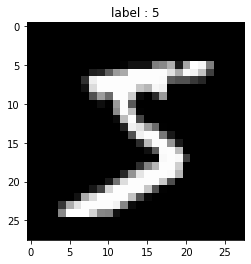

In [5]:
index = 0
image = X_train[index].reshape(28, 28)

plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [6]:
#前処理 画像は0~255で表されるが、機械学習をする上では0~1のfloat型で扱う
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.min(), "-", X_train.max())
print(X_test.min(), "-", X_test.max())

0.0 - 1.0
0.0 - 1.0


In [7]:
# 正解ラベル（0から9の整数）をone-hot表現に変換する
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [9]:
class ScratchSimpleNeuralNetworkClassifier():
    """シンプルな三層ニューラルネットワーク分類器
    :attributes
        self.activation (str): 活性化関数を指定する文字列
        self.n_epoch (int): 学習を繰り返すエポック数
        self.lr (float): 学習率
        self.plot_interval (int): lossを記録する間隔
        self.verbose (bool): 学習過程を出力する場合はTrue
    """
    def __init__(self, act_func="sigmoid", n_epoch=10, lr=0.01, plot_interval=1, verbose=True):
        self.act_func = act_func
        self.n_epoch = n_epoch
        self.lr = lr
        self.plot_interval = plot_interval
        self.verbose = verbose
    
    def fit(self, X, y, X_val=None, y_val=None):
        """ニューラルネットワーク分類器を学習する。
        :parameters
            X (2d-array, (n_samples, n_features)): 訓練データの特徴量
            y (1d-array, (n_samples,)): 訓練データの正解値
            X_val (2d-array, (n_samples, n_features)): 検証データの特徴量
            y_val (1d-array, (n_samples,)): 検証データの正解値
        """
        # 損失関数値の推移を保持するattributes
        self.loss = []
        self.loss_val = []
        
        # 重みの初期値を発生させる
        n_nodes1 = 400
        n_nodes2 = 200
        self.W1, self.B1 = self.set_initial_params(X.shape[1], n_nodes1)
        self.W2, self.B2 = self.set_initial_params(n_nodes1, n_nodes2)
        self.W3, self.B3 = self.set_initial_params(n_nodes2, y.shape[1])
        
        # 学習
        for epoch in range(self.n_epoch):
            # エポックごとに乱数を変えて、ミニバッチを取得する
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=epoch)
            
            # ミニバッチ（20枚）ごとに学習をすすめる。
            for mini_X_train, mini_y_train in get_mini_batch:
                # forwardで予測値を計算して、途中のA,Zをattributesとして保持
                self.forward(mini_X_train)

                # backwardで勾配を計算して、attributesとして保持
                self.backward(mini_X_train, mini_y_train)
                
                # 勾配を元に、WとBを更新
                self.renew_params()

                if get_mini_batch._counter % self.plot_interval == 0:
                    # クロスエントロピー誤差を計算して保持
                    self.forward(X[:5000])
                    self.loss.append(self.cross_entropy_error(y[:5000], self.Z3))
                    # 検証データありの場合はそちらの結果も保持
                    if X_val is not None and y_val is not None:
                        self.forward(X_val[:5000])
                        self.loss_val.append(self.cross_entropy_error(y_val[:5000], self.Z3))

            #if self.verbose and epoch%10 == 0:  # 学習過程の出力（エポックごと）
            if len(self.loss_val) != 0:
                # 現在のエポックと、損失関数の値を表示
                print("Epoch {}:   Loss={:.5f}   Loss_valid={:.5f}".format(epoch, self.loss[-1], self.loss_val[-1]))
            else:
                # 現在のエポックと、損失関数の値を表示
                print("Epoch {}:   Loss={:.5f}".format(epoch, self.loss[-1]))
    
    def forward(self, X0):
        """フォワードプロパゲーション
        :parameters
            X0 (2d-array, (n_samples, n_features)): 訓練データ
        """
        # 第１層： A = XW + B --> Z = act(A)
        self.A1 = np.matmul(X0, self.W1) + self.B1
        self.Z1 = self.activation(self.A1)
        
        # 第２層： A = ZW + B --> Z = act(A)
        self.A2 = np.matmul(self.Z1, self.W2) + self.B2
        self.Z2 = self.activation(self.A2)
        
        # 第３層： A = ZW + B --> Z = softmax(A)
        self.A3 = np.matmul(self.Z2, self.W3) + self.B3
        self.Z3 = self.softmax(self.A3)  # 最後はソフトマックス関数で確率にする
    
    def backward(self, X, y_true):
        """バックワードプロパゲーション（誤差逆伝播）
        後ろからさかのぼって勾配を計算していき、attributesに保持していく。
        :parameters
            X (2d-array, (n_samples, n_features)): 訓練データ
            y_true (1d-array, (n_samples, 1)): 正解ラベル
        """
        # 第３層
        self.dLdA3 = self.Z3 - y_true  # (20, 10)
        self.dLdB3 = np.sum(self.dLdA3, axis=0).reshape(1, -1)  # (1, 10)
        self.dLdW3 = np.matmul(self.Z2.T, self.dLdA3)  # (200, 20) x (20, 10) = (200, 10)
        self.dLdZ2 = np.matmul(self.dLdA3, self.W3.T)  # (20, 10) x (10, 200) = (20, 200)
        
        # 第２層
        self.dLdA2 = self.back_activation(self.Z2, self.A2, self.dLdZ2)
        self.dLdB2 = np.sum(self.dLdA2, axis=0).reshape(1, -1)
        self.dLdW2 = np.matmul(self.Z1.T, self.dLdA2)
        self.dLdZ1 = np.matmul(self.dLdA2, self.W2.T)
        
        # 第１層
        self.dLdA1 = self.back_activation(self.Z1, self.A1, self.dLdZ1)
        self.dLdB1 = np.sum(self.dLdA1, axis=0)
        self.dLdW1 = np.matmul(X.T, self.dLdA1)        
    
    def set_initial_params(self, n_features, n_nodes):
        """重み・バイアスの初期値を平均=0, 分散=σ^2 の正規分布で発生させる
        :parameters
            n_features (int): 特徴量数
            n_nodes (int): ノード数
        """
        # 正規分布の標準偏差
        sigma = 0.01
        # 乱数で発生
        W = sigma * np.random.randn(n_features, n_nodes)
        B = sigma * np.random.randn(1, n_nodes)
        return W, B
    
    def activation(self, A):
        if self.act_func == "sigmoid":
            Z = 1 / (1 + np.exp(-A))
        elif self.act_func == "tanh":
            Z = np.tanh(A)
        else:
            Z = A
        return Z
    
    def back_activation(self, Z, A, dLdZ):
        if self.act_func == "sigmoid":
            dLdA = dLdZ * Z * (1 - Z)
        elif self.act_func == "tanh":
            dLdA = dLdZ * (1 - np.tanh(A)**2)
        return dLdA
    
    def softmax(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
    
    def cross_entropy_error(self, y, Z):
        """交差エントロピー誤差の計算
        :parameters
            y (2d-array, (n_samples, n_class)): クラスの正解ラベル（one-hotなので0 or 1）
            Z (2d-array, (n_samples, n_class)): クラス分類の予測確率（yと同じ形状）
        """
        L = -1/Z.shape[0] * np.sum(y * np.log(Z))
        return L
    
    def renew_params(self):
        """パラメータ更新式（確率的勾配降下法）
        """
        self.W1 -= self.lr * self.dLdW1
        self.B1 -= self.lr * self.dLdB1
        self.W2 -= self.lr * self.dLdW2
        self.B2 -= self.lr * self.dLdB2
        self.W3 -= self.lr * self.dLdW3
        self.B3 -= self.lr * self.dLdB3
    
    def predict(self, X):
        """ニューラルネットワーク分類器を使い推定する。
        :parameters
            X (2d-array, (n_samples, n_features)): サンプル
        :returns
            label (1d-array, (n_samples, 1)): 推定結果
        """
        self.forward(X)
        label = np.argmax(self.Z3, axis=1)
        return label

In [10]:
class GetMiniBatch:
    """ミニバッチを取得するイテレータ
    :parameters
        X (2d-array, (n_samples, n_features)): 訓練データ
        y (1d-array, (n_samples, 1)): 正解値
        batch_size (int): バッチサイズ
        seed (int): 乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
ex_get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(ex_get_mini_batch))
print(ex_get_mini_batch[5][0].shape)
print(ex_get_mini_batch[5][0])
print(ex_get_mini_batch[5][1].shape)
print(ex_get_mini_batch[5][1])
for ex_mini_X_train, ex_mini_y_train in ex_get_mini_batch:
    if ex_get_mini_batch._counter % 100 == 0:
        print(ex_get_mini_batch._counter, end=" ")

2400
(20, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(20, 10)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 

# 【問題1】重みの初期値を決めるコードの作成

ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。  
重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。  

以下のメソッドをScratchSimpleNeuralNetworkClassifierに実装した。
```python
def set_initial_params(self, n_features, n_nodes):
    """重み・バイアスの初期値を平均=0, 分散=σ^2 の正規分布で発生させる
    :parameters
        n_features (int): 特徴量数
        n_nodes (int): ノード数
    """
    # 正規分布の標準偏差
    sigma = 0.01
    # 乱数で発生
    W = sigma * np.random.randn(n_features, n_nodes)
    B = sigma * np.random.randn(1, n_nodes)
    return W, B
```

# 【問題2】フォワードプロパゲーションの実装

三層のニューラルネットワークの フォワードプロパゲーション を作成してください。  

以下のメソッドをScratchSimpleNeuralNetworkClassifierに実装した。  
- 活性化関数  
```python
def activation(self, A):
    if self.act_func == "sigmoid":
        Z = 1 / (1 + np.exp(-A))
    elif self.act_func == "tanh":
        Z = np.tanh(A)
    else:
        Z = A
    return Z
```  

- softmax関数  
```python
def softmax(self, A):
    Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
    return Z
```  

- フォワードプロパゲーション  
```python
def forward(self, X0):
    """フォワードプロパゲーション
    :parameters
        X0 (2d-array, (n_samples, n_features)): 訓練データ
    """
    # 第１層： A = XW + B --> Z = act(A)
    self.A1 = np.matmul(X0, self.W1) + self.B1
    self.Z1 = self.activation(self.A1)

    # 第２層： A = ZW + B --> Z = act(A)
    self.A2 = np.matmul(self.Z1, self.W2) + self.B2
    self.Z2 = self.activation(self.A2)

    # 第３層： A = ZW + B --> Z = softmax(A)
    self.A3 = np.matmul(self.Z2, self.W3) + self.B3
    self.Z3 = self.softmax(self.A3)  # 最後はソフトマックス関数で確率にする
```

# 【問題3】交差エントロピー誤差の実装

目的関数（損失関数）を作成します。  
多クラス分類の目的関数である交差エントロピー誤差$L$は次の数式です。
$$
L = - \frac{1}{n_b}\sum_{j}^{n_b}\sum_{k}^{n_c}y_{jk} log(z_{3\_jk})
$$
$y_{ij}$:$j$番目のサンプルの$k$番目のクラスの正解ラベル  
$z_{3_ij}$:$j$番目のサンプルの$k$番目のクラスの確率(スカラー)  
$n_{b}$:バッチサイズ、batch_size  
$n_{c}$:クラスの数、n_output(今回のMNISTでは10)  
サンプル1つあたりの誤差が求まります。

以下のメソッドをScratchSimpleNeuralNetworkClassifierに実装した。
```python
def cross_entropy_error(self, y, Z):
    """交差エントロピー誤差の計算
    :parameters
        y (2d-array, (n_samples, n_class)): クラスの正解ラベル（one-hotなので0 or 1）
        Z (2d-array, (n_samples, n_class)): クラス分類の予測確率（yと同じ形状）
    """
    L = -1/Z.shape[0] * np.sum(y * np.log(Z))
    return L
```

# 【問題4】バックプロパゲーションの実装

三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。  
数式を以下に示します。  
まず、$i$層目の重みとバイアスの更新式です。   
$W_i$と$B_i$に対し、更新後の$W_i^{\prime}$と$B_i^{\prime}$は次の数式で求められます。
$$
W_i^{\prime} = W_i - \alpha \frac{\partial L}{\partial W_i} \\
B_i^{\prime} = B_i - \alpha \frac{\partial L}{\partial B_i}
$$
$\alpha$: 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）  
$\frac{\partial L}{\partial W_i}$:$W_i$に関する損失$L$の勾配  
$\frac{\partial L}{\partial B_i}$:$B_i$に関する損失$L$の勾配

以下のメソッドをScratchSimpleNeuralNetworkClassifierに実装した。  
- 誤差逆伝播法で勾配を計算
```python
def backward(self, X, y_true):
    """バックワードプロパゲーション（誤差逆伝播）
    後ろからさかのぼって勾配を計算していき、attributesに保持していく。
    :parameters
        X (2d-array, (n_samples, n_features)): 訓練データ
        y_true (1d-array, (n_samples, 1)): 正解ラベル
    """
    # 第３層
    self.dLdA3 = self.Z3 - y_true  # (20, 10)
    self.dLdB3 = np.sum(self.dLdA3, axis=0).reshape(1, -1)  # (1, 10)
    self.dLdW3 = np.matmul(self.Z2.T, self.dLdA3)  # (200, 20) x (20, 10) = (200, 10)
    self.dLdZ2 = np.matmul(self.dLdA3, self.W3.T)  # (20, 10) x (10, 200) = (20, 200)

    # 第２層
    self.dLdA2 = self.back_activation(self.Z2, self.A2, self.dLdZ2)
    self.dLdB2 = np.sum(self.dLdA2, axis=0).reshape(1, -1)
    self.dLdW2 = np.matmul(self.Z1.T, self.dLdA2)
    self.dLdZ1 = np.matmul(self.dLdA2, self.W2.T)

    # 第１層
    self.dLdA1 = self.back_activation(self.Z1, self.A1, self.dLdZ1)
    self.dLdB1 = np.sum(self.dLdA1, axis=0)
    self.dLdW1 = np.matmul(X.T, self.dLdA1)
```

- 活性化関数の逆伝播  
```python
def back_activation(self, Z, A, dLdZ):
    if self.act_func == "sigmoid":
        dLdA = dLdZ * Z * (1 - Z)
    elif self.act_func == "tanh":
        dLdA = dLdZ * (1 - np.tanh(A)**2)
    return dLdA
```

- データから学習  
```python
def fit(self, X, y, X_val=None, y_val=None):
    """ニューラルネットワーク分類器を学習する。
    :parameters
        X (2d-array, (n_samples, n_features)): 訓練データの特徴量
        y (1d-array, (n_samples,)): 訓練データの正解値
        X_val (2d-array, (n_samples, n_features)): 検証データの特徴量
        y_val (1d-array, (n_samples,)): 検証データの正解値
    """
    # 損失関数値の推移を保持するattributes
    self.loss = []
    self.loss_val = []

    # 重みの初期値を発生させる
    n_nodes1 = 400
    n_nodes2 = 200
    self.W1, self.B1 = self.set_initial_params(X.shape[1], n_nodes1)
    self.W2, self.B2 = self.set_initial_params(n_nodes1, n_nodes2)
    self.W3, self.B3 = self.set_initial_params(n_nodes2, y.shape[1])

    # 学習
    for epoch in range(self.n_epoch):
        # エポックごとに乱数を変えて、ミニバッチを取得する
        get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=epoch)

        # ミニバッチ（20枚）ごとに学習をすすめる。
        for mini_X_train, mini_y_train in get_mini_batch:
            # forwardで予測値を計算して、途中のA,Zをattributesとして保持
            self.forward(mini_X_train)

            # backwardで勾配を計算して、attributesとして保持
            self.backward(mini_X_train, mini_y_train)

            # 勾配を元に、WとBを更新
            self.renew_params()

            if get_mini_batch._counter % self.plot_interval == 0:
                # クロスエントロピー誤差を計算して保持
                self.forward(X[:5000])
                self.loss.append(self.cross_entropy_error(y[:5000], self.Z3))
                # 検証データありの場合はそちらの結果も保持
                if X_val is not None and y_val is not None:
                    self.forward(X_val[:5000])
                    self.loss_val.append(self.cross_entropy_error(y_val[:5000], self.Z3))

        #if self.verbose and epoch%10 == 0:  # 学習過程の出力（エポックごと）
        if len(self.loss_val) != 0:
            # 現在のエポックと、損失関数の値を表示
            print("Epoch {}:   Loss={:.5f}   Loss_valid={:.5f}".format(epoch, self.loss[-1], self.loss_val[-1]))
        else:
            # 現在のエポックと、損失関数の値を表示
            print("Epoch {}:   Loss={:.5f}".format(epoch, self.loss[-1]))
```

- パラメータ更新  
```python
def renew_params(self):
    """パラメータ更新式（確率的勾配降下法）
    """
    self.W1 -= self.lr * self.dLdW1
    self.B1 -= self.lr * self.dLdB1
    self.W2 -= self.lr * self.dLdW2
    self.B2 -= self.lr * self.dLdB2
    self.W3 -= self.lr * self.dLdW3
    self.B3 -= self.lr * self.dLdB3
```

# 【問題5】推定

推定を行うメソッドを作成してください。  
フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

以下のメソッドをScratchSimpleNeuralNetworkClassifierに実装した。
```python
def predict(self, X):
    """ニューラルネットワーク分類器を使い推定する。
    :parameters
        X (2d-array, (n_samples, n_features)): サンプル
    :returns
        label (1d-array, (n_samples, 1)): 推定結果
    """
    self.forward(X)
    label = np.argmax(self.Z3, axis=1)
    return label
```

# 【問題6】学習と推定

MNISTのデータを学習・推定し、Accuracyを計算してください。

In [12]:
nn = ScratchSimpleNeuralNetworkClassifier(n_epoch=20, plot_interval=10)
ex_w1, ex_b1 = nn.set_initial_params(ex_mini_X_train.shape[1], 400)
nn.fit(X_train, y_train, X_val, y_val)

Epoch 0:   Loss=1.72280   Loss_valid=1.71712
Epoch 1:   Loss=0.55330   Loss_valid=0.52172
Epoch 2:   Loss=0.32874   Loss_valid=0.30748
Epoch 3:   Loss=0.25210   Loss_valid=0.24155
Epoch 4:   Loss=0.19918   Loss_valid=0.19161
Epoch 5:   Loss=0.19120   Loss_valid=0.18671
Epoch 6:   Loss=0.14779   Loss_valid=0.14642
Epoch 7:   Loss=0.13669   Loss_valid=0.13500
Epoch 8:   Loss=0.10235   Loss_valid=0.11127
Epoch 9:   Loss=0.09176   Loss_valid=0.10835
Epoch 10:   Loss=0.08987   Loss_valid=0.10846
Epoch 11:   Loss=0.08146   Loss_valid=0.09737
Epoch 12:   Loss=0.07375   Loss_valid=0.09791
Epoch 13:   Loss=0.05686   Loss_valid=0.08494
Epoch 14:   Loss=0.05248   Loss_valid=0.08892
Epoch 15:   Loss=0.04693   Loss_valid=0.08653
Epoch 16:   Loss=0.04015   Loss_valid=0.07668
Epoch 17:   Loss=0.04080   Loss_valid=0.08134
Epoch 18:   Loss=0.03376   Loss_valid=0.07541
Epoch 19:   Loss=0.03261   Loss_valid=0.08112


In [13]:
from sklearn.metrics import accuracy_score

print("Validation Data")
y_pred = nn.predict(X_val)
y_true = np.argmax(y_val, axis=1)
print(y_pred.shape)
print(y_true.shape)
acc = accuracy_score(y_true, y_pred)
print("accuracy = {:.5f}".format(acc))

print()
print("Test Data")
y_pred_test = nn.predict(X_test)
y_true_test = y_test
print(y_pred_test.shape)
print(y_true_test.shape)
acc_test = accuracy_score(y_true_test, y_pred_test)
print("accuracy = {:.5f}".format(acc_test))

Validation Data
(12000,)
(12000,)
accuracy = 0.97442

Test Data
(10000,)
(10000,)
accuracy = 0.97370


# 【問題7】学習曲線のプロット

学習曲線をプロットしてください。
ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。  
訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

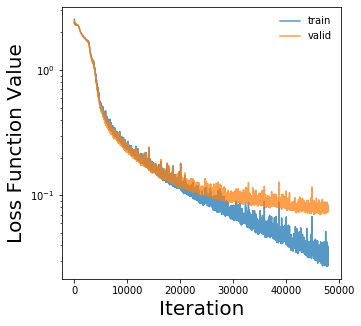

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
x1 = np.arange(len(nn.loss))
y1 = nn.loss
x2 = np.arange(len(nn.loss_val))
y2 = nn.loss_val

ax.plot(x1, y1, label="train", alpha=0.75)
ax.plot(x2, y2, label="valid", alpha=0.75)

xticks = ax.get_xticks()
ax.set_xticklabels((xticks * nn.plot_interval).astype(np.int))

ax.set_xlabel("Iteration", fontsize=20)
ax.set_ylabel("Loss Function Value", fontsize=20)
ax.set_yscale("log")
ax.legend(frameon=False)
plt.show()